# Analyzing Mutations with Trained Models

In this tutorial, we will explore some of Selene's tools for exploring and interpreting sequence predictions.
We are generally interested in models that predict various output labels for an input biological sequence.
For instance, we might want to predict histone marks from the DNA sequence of a human genome.
Beyond recapitulating biological phenomena for known motifs, these models can make accurate predictions for arbitrary sequences.
An *in silico* mutagenesis experiment uses this fact to estimate how mutations in a sequence might change our predictions for it.
In this tutorial, we will use selene's suite of tools for *in silico* mutagenesis to predict the effects of single nucleotide polymorphisms (SNPs).

**Prerequisites**
* [Getting Started with Selene](https://selene.flatironinstitute.org/tutorials/getting_started_with_selene.html)

## Download the data

After downloading the compressed data from [here](), extract it in the current directory.
The decompressed output should include the data files `sequences.fasta`, `sequences.fasta.fai`, and `distinct_features.txt`.
We will analyze the genomic sequences in `sequences.fasta` with an *in silico* mutagenesis experiment.
The second file, `sequences.fasta.fai` is a [faidx](http://www.htslib.org/doc/faidx.html) index for `sequences.fasta`.
Lastly, `distinct_features.txt` contains the names of the labels predicted by the model.
There should also be two additional files, `deepsea2.py` and `deepsea2_checkpoint.pth.tar`, containing the model class and a model checkpoint for that class.

## Load the trained model
We now build the model and load the checkpoint.
Note that if we do not have access to a CUDA-enabled GPU, we add the `map_location` argument to the call to `torch.load`.

In [3]:
import torch
from deepsea2 import DeepSEA2

model = DeepSEA2(1000, 108)
checkpoint = torch.load("deepsea2_checkpoint.pth.tar", map_location={"cuda:0": "cpu"})
model.load_state_dict(checkpoint["state_dict"])
model.eval()

DeepSEA2(
  (conv_net): Sequential(
    (0): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace)
    (2): Conv1d(320, 320, kernel_size=(8,), stride=(1,))
    (3): ReLU(inplace)
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True)
    (6): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
    (7): ReLU(inplace)
    (8): Conv1d(480, 480, kernel_size=(8,), stride=(1,))
    (9): ReLU(inplace)
    (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True)
    (12): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
    (13): ReLU(inplace)
    (14): Conv1d(960, 960, kernel_size=(8,), stride=(1,))
    (15): ReLU(inplace)
    (16): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True)
    (17): Dropout(p=0.2)
  )
  (classifier): Sequential(
    (0): Linear(in_features=42240, out_features=108, bias=True

## *In silico* mutagenesis

In an *in silico* mutagenesis experiment, we have some input sequence $S$ of length $L$ which we would like to mutate.
In the simplest case of *in silico* mutagenesis, we make predict the effects of each individual $3L$ SNPs that are possible in $S$.
The *in silico* mutagenesis tools in selene allow us to do this easily, and can also be used to predict the effects of every pair/triplet/etc of SNPs in our input sequence.

We will now load the list of features from file, and perform an *in silico* mutagenesis experiment on the sequences in `sequences.fasta`.
This will give us predictions for the effects of every possible SNP that could occur in our sequence.
Note that this may take a minute or two if you are not using a GPU.

In [2]:
from selene.utils import load_features_list
from selene.predict import AnalyzeSequences

features = load_features_list("distinct_features.txt")
analysis = AnalyzeSequences(model, sequence_length=1000, batch_size=64, features=features)
analysis.in_silico_mutagenesis_from_file("sequences.fasta", 
                                         save_data=["diffs", "logits", "predictions"], 
                                         output_path_prefix="./ism")

NameError: name 'model' is not defined

There should now be three new files: `ism_0_predictions.tsv`, `ism_0_logits.tsv`, and `ism_0_diffs.tsv`.
They contain the results of the *in silico* mutagenesis experiments on the first record from `sequences.fasta`.
If there was second record in `sequences.fasta`, we would also see `ism_1_predictions.tsv`, `ism_1_logits.tsv`, and `ism_1_diffs.tsv`.

The first of these output files, `ism_0_predictions.tsv`, contains the model predictions for each individual SNP in the *in silico* mutagenesis experiment.
The file `ism_0_logits.tsv` contains the absolute difference between the logits of the reference and SNP predictions.
Consider that we are predicting the $i^{th}$ label for a sequence $S'$ that has been produced by mutating a single base in $S$.
Then $p_i$ is the probability that the non-mutated sequence $S$ is a positive example of the $i^{th}$ feature, and $q_i$ is the probability that the mutated sequence $S'$ is a positive example of the $i^{th}$ feature.
Thus, the corresponding values in `ism_0_logits.tsv` would be be $\left|\mathrm{logit}(q_i) -  \mathrm{logit}(p_i)\right|$ where $\mathrm{logit}(x) = \log\left(\frac{x}{1 - x}\right) = \log(x) - \log(1 - x)$.
Finally, the file `ism_0_diffs.tsv` contains the absolute difference between the reference and SNP predictions, i.e. $\left|q_i - p_i\right|$.

## Visualizing *in silico* mutagenesis results
Before we visualize anything, we have to load the predictions for the *in silico* mutagenesis of the first sequence record from `sequences.fasta`. As stated above, these predictions are in `ism_0_predictions.txt`.

In [1]:
from selene.interpret import ISMResult

ism = ISMResult.from_file("ism_0_predictions.tsv")

We now extract the array of predictions for one of the predicted labels, "H3K27ac|36041".

In [2]:
score_matrix = ism.get_score_matrix_for("H3K27ac|36041")[:50,]

The structure of the returned `score_matrix` is important, so let's take a moment to discuss it.
For a score matrix $\mathbf{X}$, the element in the $i^{th}$ row and $j^{th}$ column, $x_{i, j}$, is the prediction associated with mutating the $i^{th}$ base in the input sequence to the $j^{th}$ base in $[A, C, G, T]$.
If the $j^{th}$ base in $[A, C, G, T]$ is the same as the reference base, then $x_{i, j}$ will be the predicted value for the reference sequence.

### Plotting heatmaps
We will now plot this matrix as a heatmap, using the `heatmap` method in `selene.interpret`.
In the example below, we mask the bases that match the reference with cross-hatching.

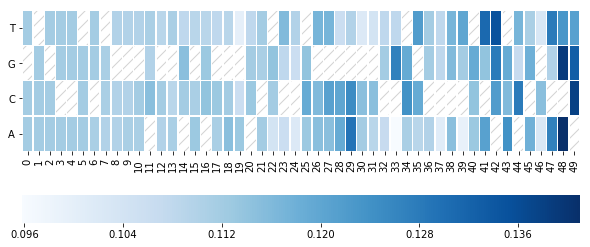

In [3]:
import matplotlib.pyplot as plt
import selene.interpret
from selene.sequences import Genome

reference_encoding = Genome.sequence_to_encoding(ism.reference_sequence)[:50,] == 1.
figure, (ax) = plt.subplots(1, 1, figsize=(10, 4))
ax.patch.set(edgecolor="lightgrey", hatch="//")
selene.interpret.heatmap(score_matrix, mask=reference_encoding, cbar=True, ax=ax, linewidth=0.5)

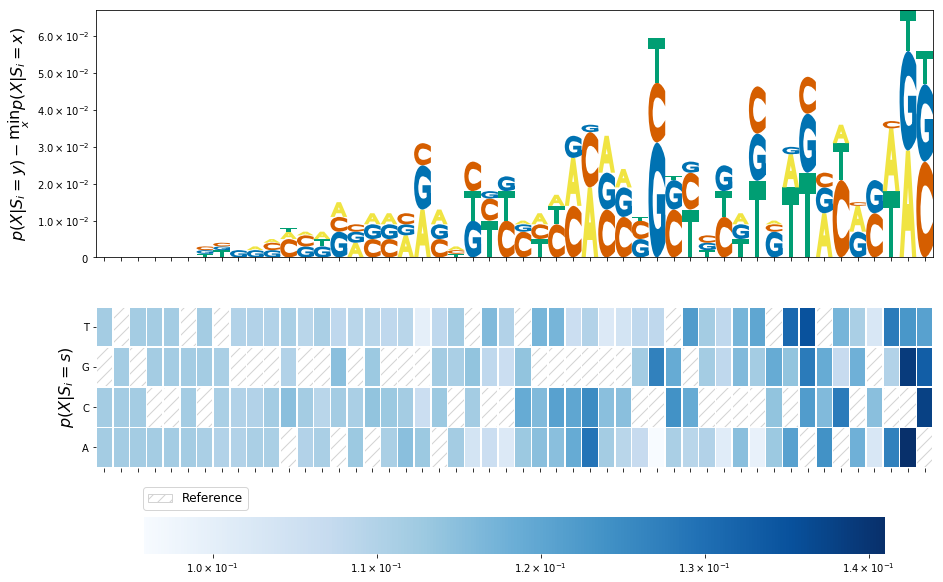

In [23]:
from matplotlib.patches import Patch
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
rescaled_score_matrix = selene.interpret.rescale_score_matrix(score_matrix, base_scaling="max_effect")
selene.interpret.sequence_logo(rescaled_score_matrix, ax=ax1,  
                               color_scheme=["#F0E442", "#D55E00", "#0072B2", "#009E73"])
ax1.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
ax1.set_yticklabels([r"$0$", r"$1.0\times10^{-2}$", r"$2.0\times10^{-2}$", 
                     r"$3.0\times10^{-2}$", r"$4.0\times10^{-2}$", r"$5.0\times10^{-2}$",
                     r"$6.0\times10^{-2}$"])


selene.interpret.heatmap(score_matrix, cbar=True, ax=ax2, linewidth=0.5, cmap="Blues", mask=reference_encoding)

ax2.patch.set(edgecolor="lightgrey", hatch="//")
ax2.collections[0].colorbar.set_ticks([100e-3, 110e-3, 120e-3, 130e-3, 140e-3])
ax2.collections[0].colorbar.set_ticklabels([r"$1.0\times10^{-1}$", r"$1.1\times10^{-1}$",
                                            r"$1.2\times10^{-1}$", r"$1.3\times10^{-1}$", 
                                            r"$1.4\times10^{-1}$"])
ax2.set_ylabel(r"$p(X|S_i=s)$", fontsize=16)
ax1.set_ylabel(r"$p(X|S_i=y) - \min_x p(X|S_i=x)$", fontsize=16)
# ax1.set_ylabel("Maximum effect size", fontsize=16)
# ax2.set_ylabel("Probability", fontsize=16)
ax2.set_xticklabels([])
ax1.set_xticklabels([])
ref_guide = Patch(fill="", edgecolor="lightgrey", hatch="//", label="Reference")
ax2.collections[0].colorbar.ax.legend(loc="center left", ncol=2, bbox_to_anchor=(-0.009, 1.5),
                                      handles=[ref_guide], labels=["Reference"], fontsize=12)

#bbox_to_anchor=(-0.009, 1.7),
                                      

plt.savefig("selene_fig.with_labels.marked_up.math_labels.no_ticks.large_font.svg", format="svg")
# ax2.collections[0].colorbar.set_ticklabels(["5e-2", "1e-1", "1.5e-1", "2e-1"])
                                            
                                            #r"$5\times10^{-4}$",  r"$1\times10^{-3}$",  r"$1.5\times10^{-3}$", r"$2\times10^{-3}$",  r"$2.5\times10^{-3}$"])
plt.show()

### Plotting sequence logos
In the code below, we've plotted the matrix as a sequence logo using the `sequence_logo` method from `selene.interpret`.
The vertical ordering of the bases at each position can be controlled with the `order` argument to `sequence_logo`.
With `order="alpha"`, at the $i^{th}$ position along the horizontal axis, the height of the $j^{th}$ letter is the value $x_{i, j}$ from the score matrix.
However, it is more common to order the bases at each position in a sequence logo by the value of their prediction.
This behavior can be achieved with `order="value"`.

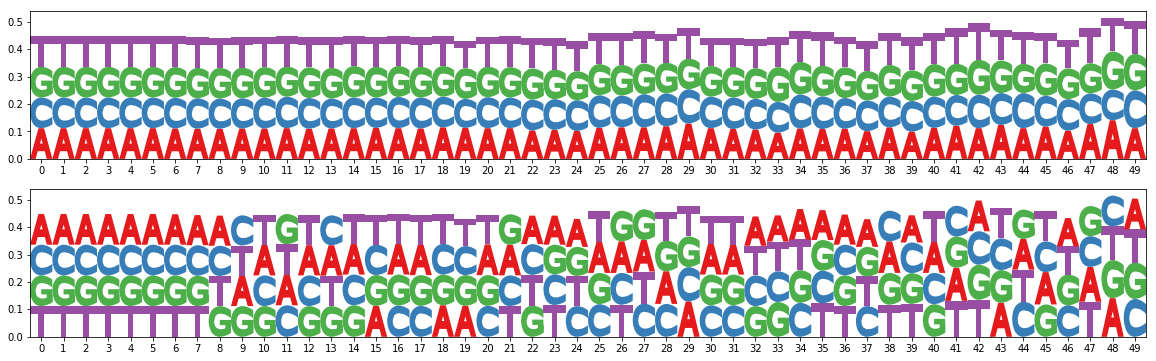

In [66]:
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
selene.interpret.sequence_logo(score_matrix, order="alpha", ax=ax1)
selene.interpret.sequence_logo(score_matrix, order="value", ax=ax2)

### Rescaling predictions
Besides visualization methods, `selene.interpret` contains tools for rescaling the plotted values.
Although we often want to plot the raw values as we did above, there are other derived values that we are interested in.
The method `rescale_score_matrix` in `selene.interpret` enables easy calculation of many of these values.
Rescaling with `rescale_score_matrix` can be performed on the individual bases at a loci, or each position in the sequence.

Position-wise scaling is controlled by the `position_scaling` argument to `rescale_score_matrix`, which may be either `"identity"`, `"probability"`, or `"max_effect"`.
The first of these, `"identity"`, performs no position-wise rescaling.
The second, `"probability"`, rescales the values so that the predictions for each base at a given position in the sequence sum to $1$.
Finally, `"max_effect"` scaling is nearly identical to that of `"probability"`, but values are rescaled so that the predictions for each base at a given position in the sequence sum to the difference between the largest and smallest predicted values.

Base-wise scaling is controlled by the `base_scaling` argument to `rescale_score_matrix`, which maybe either `"identity"`, `"probability"`, or `"max_effect"`.
The first, `"identity"`, does not rescale any values.
Since the inputs are assumed to be probabilities to begin with, `"probability"` does not rescale input values either.
Lastly, `"max_effect"` rescales the values so that the predictions for each base at a given position in the sequence is the difference between that prediction and the smallest prediction at that position.


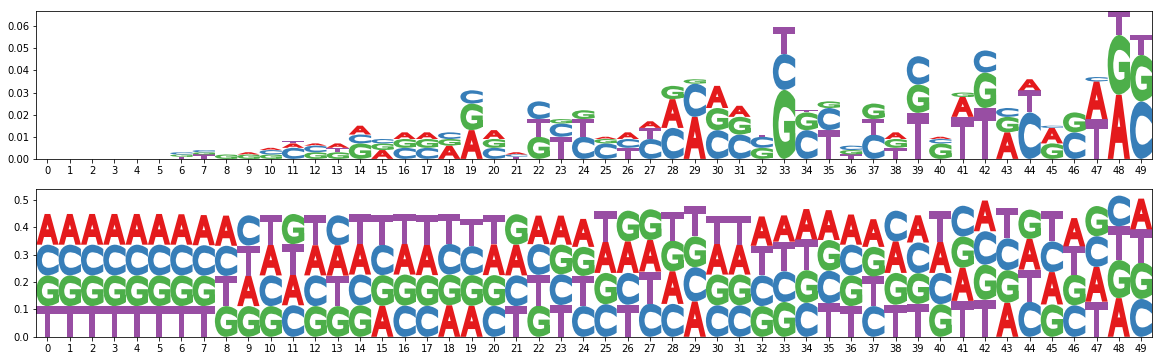

In [98]:
rescaled_score_matrix = selene.interpret.rescale_score_matrix(score_matrix, base_scaling="max_effect")
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
selene.interpret.sequence_logo(rescaled_score_matrix, ax=ax1)
selene.interpret.sequence_logo(score_matrix, ax=ax2)